# Fast Marching Method
### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../../thesis/figures/fmm/"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.9)

from skimage import io
import numpy as np

import concurrent.futures
import json

from helper_funcs import save_fig, make_cache, get_val_arr, \
                         print_table_nums, hit_to_misses, \
                         MORTON, ROW_ARR, BLOCK_ARR

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

from algorithms.fmm import fmm, get_path

In [3]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## First test that it looks to be correct on a small 2D array

In [4]:
speed_arr = [
    [20,    20,    20, 0.1],
    [0.001, 0.001, 20, 0.2],
    [0.001, 0.001, 20, 0.001],
    [0.001, 20,    20, 20]
]

[[0.00000000e+00 5.00000000e-02 1.00000000e-01 6.70250129e+00]
 [9.96733446e+02 7.07206779e+02 1.50000000e-01 5.15000000e+00]
 [1.28009329e+03 5.55027113e+02 2.00000000e-01 7.07356779e+02]
 [6.66983333e+02 3.00000000e-01 2.50000000e-01 3.00000000e-01]]


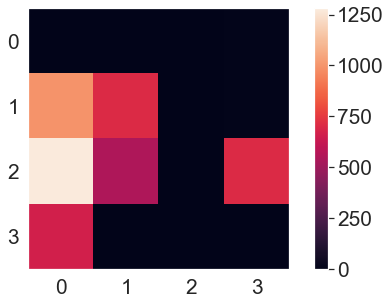

In [5]:
import skfmm

phi = np.ones((4,4))
phi[0,0] = 0
exp = skfmm.travel_time(phi, speed_arr)
print(exp)

plt.imshow(exp)
plt.colorbar()
plt.grid()
plt.show()

[[ 0.          0.04987531  0.09975062  6.38166487]
 [18.96064472 13.96449976  0.14962594  4.14962594]
 [30.18881625 14.1141257   0.19950125 14.1141257 ]
 [19.90709501  0.29925187  0.24937656  0.29925187]]


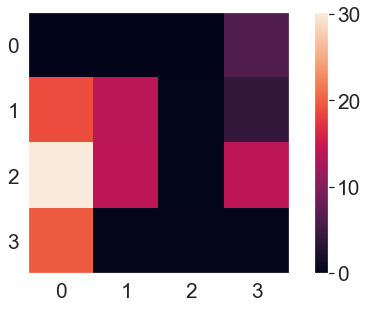

In [6]:
morton = MortonOrder(picture=speed_arr)
fmm_morton, neighbors = fmm(morton, (0,0))
print(fmm_morton)
plt.imshow(fmm_morton.to_numpy())
plt.colorbar()
plt.grid()
plt.show()

## Now test on a blood vessel image

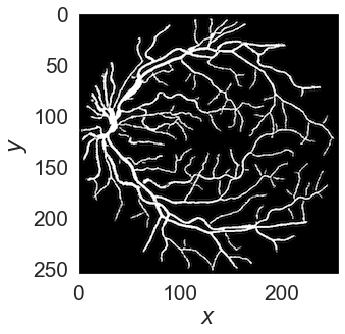

In [7]:
# Original image from
# https://www-sciencedirect-com.ep.fjernadgang.kb.dk/science/article/pii/S0895611118302313
img = io.imread('img/vessels.png', as_gray=True)

plt.imshow(img, cmap='gray')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
#plt.title("Original image")
save_fig("vessel-original.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

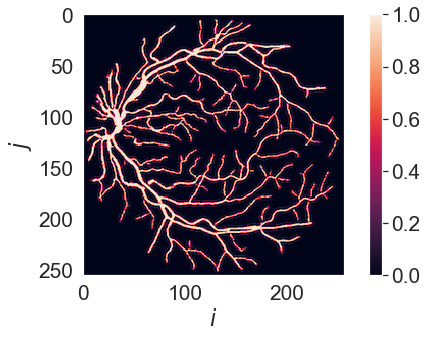

In [8]:
plt.imshow(img)
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
#plt.title("Speed function $f_{ij}$")
plt.colorbar()
save_fig("speed-func.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

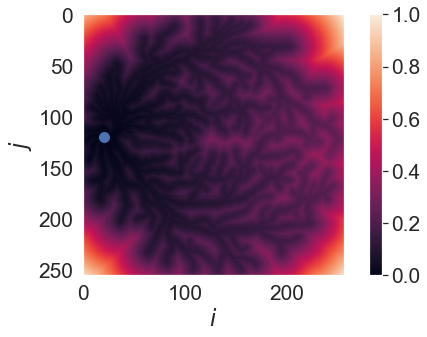

In [9]:
start_point = (120, 20)
morton = MortonOrder(img)
tij, neighbors = fmm(morton, start_point)

plt.imshow(tij.to_numpy())
plt.colorbar()
plt.scatter(start_point[1], start_point[0], color='b', s=100, label="Start point")
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
save_fig("time-func-00.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

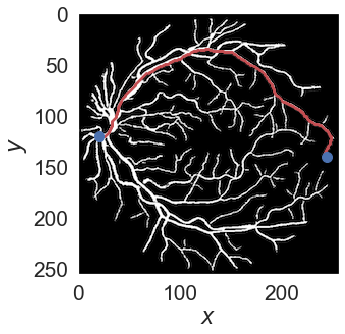

In [10]:
end_point = (140, 244)
path = get_path(neighbors, end_point)
plt.imshow(img, cmap='gray')

plt.scatter(path[:, 1], path[:, 0], color='r', s=3)
plt.scatter(start_point[1], start_point[0], color='b', s=100, label="Start point")
plt.scatter(end_point[1], end_point[0], color='b', s=100, label="End point")

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
save_fig("time-func-00-path.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

(128, 128)


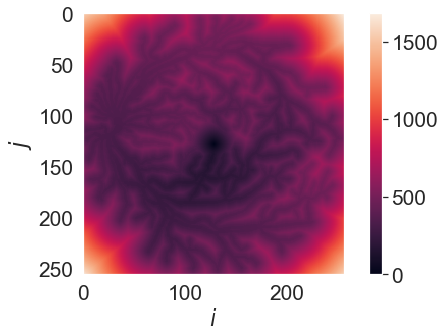

In [11]:
start_point = (256//2, 256//2)
print(start_point)
morton = MortonOrder(img)
tij, _ = fmm(morton, start_point)


plt.imshow(tij.to_numpy())
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
#plt.title("Time function $T_{ij}$ originating from " + str(start_point))
plt.colorbar()
save_fig("time-func-mid.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

## Defining functions/variables to run tests

In [12]:
def results_for_n(n, dim):    
    cs1 = make_cache()
    cs2 = make_cache()
    cs3 = make_cache()
    
    start = (0, 0) if dim == 2 else (0, 0, 0)
    rnd_vals = np.random.rand(n, n) if dim == 2 else np.random.rand(n, n, n)
    
    morton = MortonOrder(rnd_vals, cache=cs1)
    row_arr = RowMajorArray(rnd_vals, cache=cs2)
    block_arr = BlockArray(rnd_vals, cache=cs3)

    # Warm up
    fmm(morton, start)
    fmm(row_arr, start)
    fmm(block_arr, start)

    # Reset caches
    cs1.force_write_back()
    cs1.reset_stats()
    cs2.force_write_back()
    cs2.reset_stats()
    cs3.force_write_back()
    cs3.reset_stats()

    # Do actual test
    fmm(morton, start)
    fmm(row_arr, start)
    fmm(block_arr, start)
    
    cs1.force_write_back()
    cs2.force_write_back()
    cs3.force_write_back()

    print(f"{n} finished")
    return {
        MORTON: list(cs1.stats()),
        ROW_ARR: list(cs2.stats()),
        BLOCK_ARR: list(cs3.stats())
    }

In [13]:
ns_2d = [2**i for i in range(4, 12)]
print(ns_2d)

ns_3d = [2**i for i in range(3, 9)]
print(ns_3d)

[16, 32, 64, 128, 256, 512, 1024, 2048]
[8, 16, 32, 64, 128, 256]


## Generating/loading in test results

### 2D
NB: For some reason `concurrent.futures` kept erroring out, so only done on a single core

In [14]:
if GENERATE_NEW_RESULTS:
    np.random.seed(0)  # Make results reproducable
    dim = 2

    results_2d = {}
    for n in ns_2d:
        print(n)
        results_2d[n] = results_for_n(n, dim)
        
    with open('results/fmm-result-2d.json', 'w') as f:
        json.dump(results_2d, f, indent=4)


with open('results/fmm-result-2d.json', 'r') as f:
    results_2d = json.load(f)

## 3D

In [15]:
if GENERATE_NEW_RESULTS:
    np.random.seed(0)  # Make results reproducable
    dim = 3

    results_3d = {}
    for n in ns_3d:
        print(n)
        results_3d[n] = results_for_n(n, dim)

    with open('results/fmm-result-3d.json', 'w') as f:
        json.dump(results_3d, f, indent=4)


with open('results/fmm-result-3d.json', 'r') as f:
    results_3d = json.load(f)

## Plotting

In [16]:
def make_plot(dim, cache_level=0, stat="HIT_count"):
    results = results_2d if dim == 2 else results_3d
    labels = ns_2d if dim == 2 else ns_3d

    row_arr_res = get_val_arr(results, ROW_ARR, stat=stat)
    morton_res = get_val_arr(results, MORTON, stat=stat) / row_arr_res
    block_arr_res = get_val_arr(results, BLOCK_ARR, stat=stat) / row_arr_res
    row_arr_res = row_arr_res / row_arr_res # All 1's

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars
    block_arr_name = "PixelBlockArray" if dim == 2 else "VoxelBlockArray"

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, morton_res, width, label="MortonOrder")
    rects2 = ax.bar(x, row_arr_res, width, label="RowMajorArray")
    rects3 = ax.bar(x + width, block_arr_res, width, label=block_arr_name)

    stat_simple_label = stat.lower().replace("_", " ")
    ax.set_ylabel(f"Relatve {stat_simple_label}")
    ax.set_xlabel("$n$")
    #ax.set_title(f"Relatve {stat} (scaled by RowMajorArray) during {dim}D FMM")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc=4)

    fig.tight_layout()
    save_fig(f"{stat}-{dim}d.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

    plt.show()

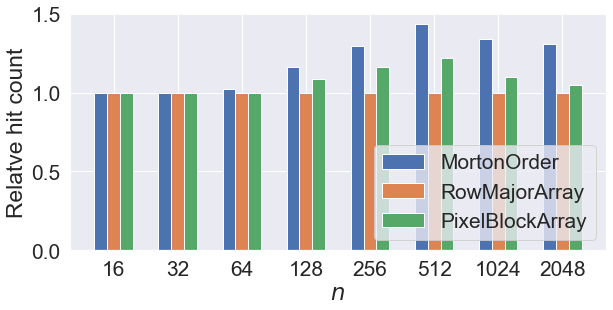

In [17]:
make_plot(2)

Note: Errors out because of zero-division (because of no cache misses), but plot comes out correct

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


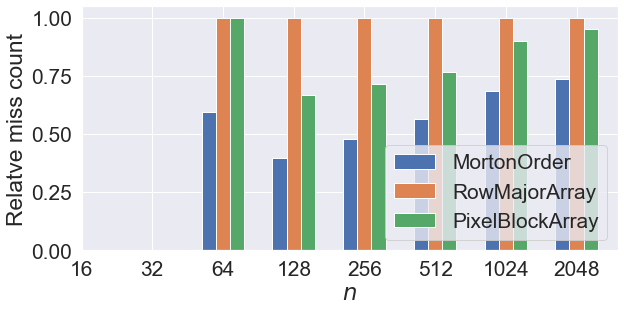

In [18]:
make_plot(2, stat="MISS_count")

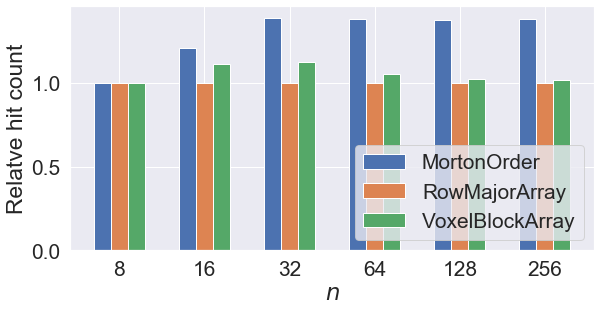

In [19]:
make_plot(3)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


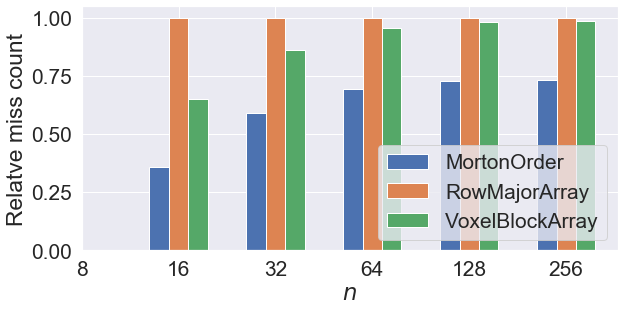

In [20]:
make_plot(3, stat="MISS_count")

### Numbers used in report for table:

In [21]:
for stat in ["HIT_count", "MISS_count"]:
    print(stat)
    for dim, results, ns in zip([2, 3], [results_2d, results_3d], [ns_2d, ns_3d]):
        print_table_nums(dim, results, ns, stat)
        
print("HIT_TO_MISS")
for dim, results, ns in zip([2, 3], [results_2d, results_3d], [ns_2d, ns_3d]):
    hit_to_misses(dim, results, ns)

HIT_count
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : 1.00 & 1.00 & 1.03 & 1.16 & 1.30 & 1.43 & 1.34 & 1.31
block_arr : 1.00 & 1.00 & 1.00 & 1.09 & 1.16 & 1.22 & 1.10 & 1.05


Dim: 3
ns        : [8, 16, 32, 64, 128, 256]
morton    : 1.00 & 1.21 & 1.39 & 1.38 & 1.38 & 1.38
block_arr : 1.00 & 1.11 & 1.13 & 1.05 & 1.02 & 1.02


MISS_count
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : nan & nan & 0.60 & 0.40 & 0.48 & 0.57 & 0.68 & 0.74
block_arr : nan & nan & 1.00 & 0.67 & 0.71 & 0.77 & 0.90 & 0.95


Dim: 3
ns        : [8, 16, 32, 64, 128, 256]
morton    : nan & 0.36 & 0.59 & 0.70 & 0.73 & 0.73
block_arr : nan & 0.65 & 0.86 & 0.96 & 0.98 & 0.99


HIT_TO_MISS
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : inf & inf & 24.16 & 9.84 & 4.35 & 2.37 & 1.73 & 1.46
row_arr   : inf & inf & 14.06 & 3.37 & 1.61 & 0.94 & 0.88 & 0.83
block_arr : inf & inf & 14.06 & 5.50 & 2.61 & 1.49 & 1.08 & 0.91


Dim: 3
ns        : [8, 16, 32

/Users/shmulvad/GoogleDrive/Uni/Bachelorprojekt/code/src/helper_funcs.py:69: RuntimeWarning: invalid value encountered in true_divide
  rel_res = get_val_arr(results, data_typ, stat=stat) / row_arr_res
/Users/shmulvad/GoogleDrive/Uni/Bachelorprojekt/code/src/helper_funcs.py:83: RuntimeWarning: divide by zero encountered in true_divide
  hit_to_misses = map(lambda val: f"{val:.2f}", hits / misses)
